In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import glob
from sklearn import linear_model
from sklearn.metrics import r2_score


from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split


import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Apartment Buy

In [3]:
path = os.path.join(os.getcwd(), "Data/Apartment/Buy/")
list_of_files = glob.glob(f"{path}/*.csv") 

In [4]:
list_df = []

for filename in list_of_files:
    df = pd.read_csv(filename, sep=";",index_col=None, header=0,usecols=["city","postcode","numberOfRooms","livingSpace","balcony","builtInKitchen","garden","price","guestToilet"])
    df=df.sample(frac=1)
    df=df[df['city']=='Berlin']
    df['price']=df['price'].apply(lambda x: float(x.split(" EUR")[0]))
    list_df.append(df)

df_total = pd.concat(list_df, axis=0, ignore_index=True)

In [5]:
for i in list(df_total.columns):
    df_total=df_total[df_total[i]!="no value"]

In [6]:
hot_zip_test = pd.get_dummies(df_total.postcode)
df_total.balcony = df_total.balcony.astype(int)
df_total.garden = df_total.garden.astype(int)
df_total.builtInKitchen = df_total.builtInKitchen.astype(int)
df_total.guestToilet = df_total.guestToilet.astype(int)

In [7]:
X = pd.concat((df_total[["numberOfRooms","livingSpace","balcony","builtInKitchen","garden","guestToilet"]], hot_zip_test), axis=1)
y = df_total[["price"]]


In [8]:
# a simple linear model doesn't perform too well
simple = linear_model.LinearRegression()
simple.fit(X,y)
y_pred = simple.predict(X)
r2_score(y, y_pred)

0.7268646337674189

In [9]:
# Robustly fit linear model with RANSAC (RANdom SAmple Consensus) algorithm 
regressor = linear_model.RANSACRegressor(linear_model.LinearRegression())

In [10]:
regressor.fit(X,y)


RANSACRegressor(base_estimator=LinearRegression())

In [11]:
inlier_mask = regressor.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(u'%.1f%% of apartments identified as outliers' % (sum(outlier_mask)*100.0/(sum(outlier_mask)+sum(inlier_mask))))

36.2% of apartments identified as outliers


In [12]:
y_pred = regressor.predict(X)
df_total["buy_predicted"] = y_pred

In [13]:
r2_ransac = r2_score(y[inlier_mask], y_pred[inlier_mask])


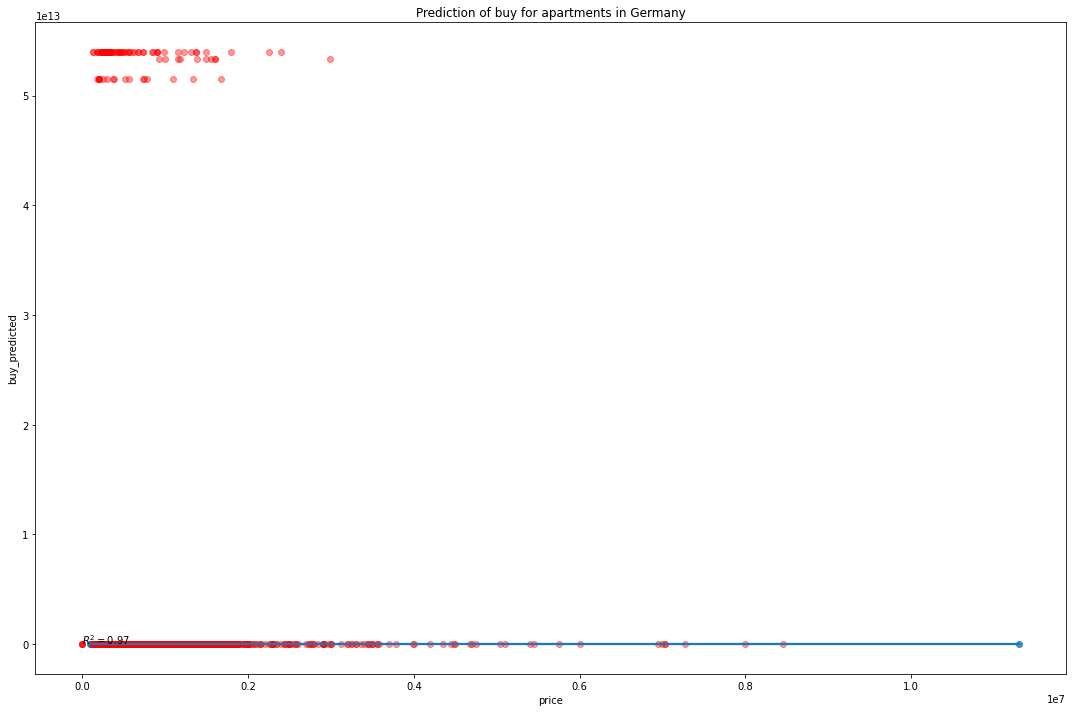

In [14]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.regplot(df_total['price'][inlier_mask],
            df_total['buy_predicted'][inlier_mask])
plt.scatter(df_total['price'][outlier_mask],
            df_total['buy_predicted'][outlier_mask],
            alpha=0.4,
            c='r')

plt.title('Prediction of buy for apartments in Germany')
plt.text(250, 2000, r'$R^2=%.2f$' % r2_ransac)
plt.tight_layout()
# plt.savefig('LinReg-rent-apartment.png', dpi=150)

In [15]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, scoring="r2")
tpot.fit(X, y)
print(tpot.score(X, y))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6814492457549359

Generation 2 - Current best internal CV score: 0.6814492457549359

Generation 3 - Current best internal CV score: 0.6905578910255048

Generation 4 - Current best internal CV score: 0.7297706410900899

Generation 5 - Current best internal CV score: 0.7297706410900899

Best pipeline: RandomForestRegressor(GradientBoostingRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.1, loss=exponential, n_estimators=100), alpha=0.99, learning_rate=0.1, loss=ls, max_depth=6, max_features=0.8, min_samples_leaf=2, min_samples_split=10, n_estimators=100, subsample=0.6500000000000001), bootstrap=False, max_features=0.2, min_samples_leaf=12, min_samples_split=10, n_estimators=100)
0.8604186203079293


In [16]:
y_pred = tpot.predict(X)
r2_score(y, y_pred)

0.8604186203079293

## House Buy

In [17]:
path = os.path.join(os.getcwd(), "Data/House/Buy/")
list_of_files = glob.glob(f"{path}/*.csv") 

In [18]:
list_df = []

for filename in list_of_files:
    df = pd.read_csv(filename, sep=";",index_col=None, header=0,usecols=["city","postcode","numberOfRooms","livingSpace","price","guestToilet"])
    df=df.sample(frac=1)
    df=df[df['city']=='Berlin']
    df['price']=df['price'].apply(lambda x: float(x.split(" EUR")[0]))
    list_df.append(df)

df_total = pd.concat(list_df, axis=0, ignore_index=True)

In [19]:
for i in list(df_total.columns):
    df_total=df_total[df_total[i]!="no value"]

In [20]:
hot_zip_test = pd.get_dummies(df_total.postcode)
df_total.guestToilet = df_total.guestToilet.astype(int)

In [21]:
X = pd.concat((df_total[["numberOfRooms","livingSpace","guestToilet"]], hot_zip_test), axis=1)
y = df_total[["price"]]


In [22]:
# a simple linear model doesn't perform too well
simple = linear_model.LinearRegression()
simple.fit(X,y)
y_pred = simple.predict(X)
r2_score(y, y_pred)

0.8983225844654354

In [23]:
# Robustly fit linear model with RANSAC (RANdom SAmple Consensus) algorithm 
regressor = linear_model.RANSACRegressor(linear_model.LinearRegression())

In [24]:
regressor.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression())

In [25]:
inlier_mask = regressor.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(u'%.1f%% of houses identified as outliers' % (sum(outlier_mask)*100.0/(sum(outlier_mask)+sum(inlier_mask))))

35.5% of houses identified as outliers


In [26]:
y_pred = regressor.predict(X)
df_total["buy_predicted"] = y

In [27]:
r2_ransac = r2_score(y[inlier_mask], y_pred[inlier_mask])

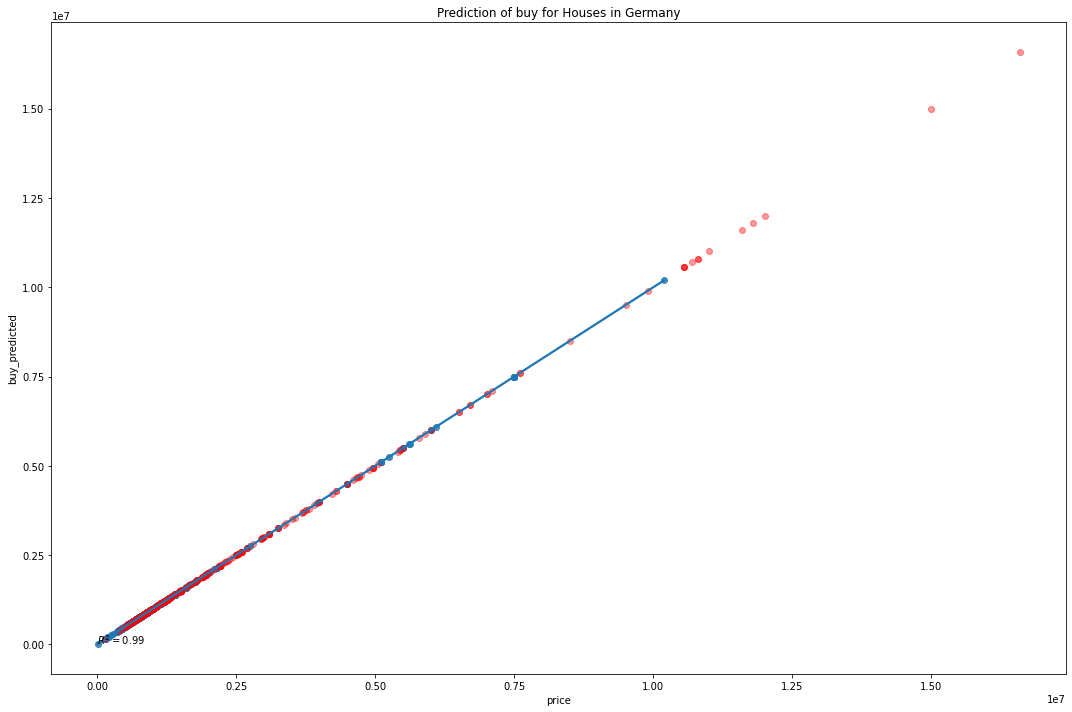

In [28]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.regplot(df_total['price'][inlier_mask],
            df_total['buy_predicted'][inlier_mask])
plt.scatter(df_total['price'][outlier_mask],
            df_total['buy_predicted'][outlier_mask],
            alpha=0.4,
            c='r')

plt.title('Prediction of buy for Houses in Germany')
plt.text(250, 2000, r'$R^2=%.2f$' % r2_ransac)
plt.tight_layout()
# plt.savefig('LinReg-rent-apartment.png', dpi=150)

In [29]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, scoring="r2")
tpot.fit(X, y)
print(tpot.score(X, y))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7940190327022976

Generation 2 - Current best internal CV score: 0.7949363975971269

Generation 3 - Current best internal CV score: 0.8132674416275629

Generation 4 - Current best internal CV score: 0.8132674416275629

Generation 5 - Current best internal CV score: 0.8143041677838513

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)
0.9472338718284852


In [30]:
y_pred = tpot.predict(X)
r2_score(y, y_pred)

0.9472338718284852

## Apartment Rent

In [31]:
path = os.path.join(os.getcwd(), "Data/Apartment/Rent/")
list_of_files = glob.glob(f"{path}/*.csv") 

In [32]:
list_df = []

for filename in list_of_files:
    df = pd.read_csv(filename, sep=";",index_col=None, header=0,usecols=["city","postcode","numberOfRooms","livingSpace","balcony","builtInKitchen","garden","price"])
    df=df.sample(frac=1)
    df=df[df['city']=='Berlin']
    df['price']=df['price'].apply(lambda x: float(x.split(" EUR")[0]))
    list_df.append(df)

df_total = pd.concat(list_df, axis=0, ignore_index=True)

In [33]:
for i in list(df_total.columns):
    df_total=df_total[df_total[i]!="no value"]

In [34]:
hot_zip_test = pd.get_dummies(df_total.postcode)
df_total.balcony = df_total.balcony.astype(int)
df_total.garden = df_total.garden.astype(int)
df_total.builtInKitchen = df_total.builtInKitchen.astype(int)

In [35]:
X = pd.concat((df_total[["numberOfRooms","livingSpace","balcony","builtInKitchen","garden"]], hot_zip_test), axis=1)
y = df_total[["price"]]


In [36]:
# a simple linear model doesn't perform too well
simple = linear_model.LinearRegression()
simple.fit(X,y)
y_pred = simple.predict(X)
r2_score(y, y_pred)

0.7576010804694424

In [37]:
# Robustly fit linear model with RANSAC (RANdom SAmple Consensus) algorithm 
regressor = linear_model.RANSACRegressor(linear_model.LinearRegression())

In [38]:
regressor.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression())

In [39]:
inlier_mask = regressor.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(u'%.1f%% of apartments identified as outliers' % (sum(outlier_mask)*100.0/(sum(outlier_mask)+sum(inlier_mask))))

33.4% of apartments identified as outliers


In [40]:
y_pred = regressor.predict(X)
df_total["rent_predicted"] = y

In [41]:
r2_ransac = r2_score(y[inlier_mask], y_pred[inlier_mask])

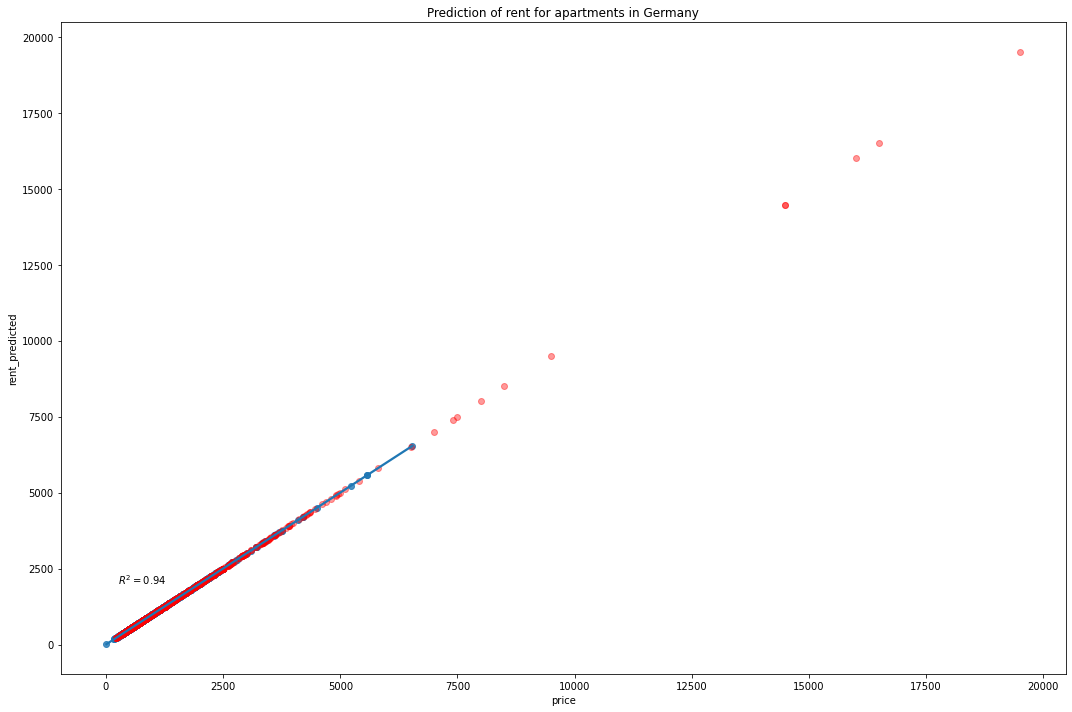

In [42]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.regplot(df_total['price'][inlier_mask],
            df_total['rent_predicted'][inlier_mask])
plt.scatter(df_total['price'][outlier_mask],
            df_total['rent_predicted'][outlier_mask],
            alpha=0.4,
            c='r')

plt.title('Prediction of rent for apartments in Germany')
plt.text(250, 2000, r'$R^2=%.2f$' % r2_ransac)
plt.tight_layout()
# plt.savefig('LinReg-rent-apartment.png', dpi=150)

In [43]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, scoring="r2")
tpot.fit(X, y)
print(tpot.score(X, y))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7046660556623822

Generation 2 - Current best internal CV score: 0.707820039634446

Generation 3 - Current best internal CV score: 0.707820039634446

Generation 4 - Current best internal CV score: 0.728696873198037

Generation 5 - Current best internal CV score: 0.728696873198037

Best pipeline: ExtraTreesRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.01, loss=exponential, n_estimators=100), bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=8, n_estimators=100)
0.9559230410677486


In [44]:
y_pred = tpot.predict(X)
r2_score(y, y_pred)

0.9559230410677486

## House Buy

In [45]:
path = os.path.join(os.getcwd(), "Data/House/Rent/")
list_of_files = glob.glob(f"{path}/*.csv") 

In [46]:
list_df = []

for filename in list_of_files:
    df = pd.read_csv(filename, sep=";",index_col=None, header=0,usecols=["city","postcode","numberOfRooms","livingSpace","price"])
    df=df.sample(frac=1)
    df=df[df['city']=='Berlin']
    df['price']=df['price'].apply(lambda x: float(x.split(" EUR")[0]))
    list_df.append(df)

df_total = pd.concat(list_df, axis=0, ignore_index=True)

In [47]:
for i in list(df_total.columns):
    df_total=df_total[df_total[i]!="no value"]

In [48]:
hot_zip_test = pd.get_dummies(df_total.postcode)

In [49]:
X = pd.concat((df_total[["numberOfRooms","livingSpace"]], hot_zip_test), axis=1)
y = df_total[["price"]]


In [50]:
# a simple linear model doesn't perform too well
simple = linear_model.LinearRegression()
simple.fit(X,y)
y_pred = simple.predict(X)
r2_score(y, y_pred)

0.8509852290615827

In [51]:
# Robustly fit linear model with RANSAC (RANdom SAmple Consensus) algorithm 
regressor = linear_model.RANSACRegressor(linear_model.LinearRegression())

In [52]:
regressor.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression())

In [53]:
inlier_mask = regressor.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(u'%.1f%% of apartments identified as outliers' % (sum(outlier_mask)*100.0/(sum(outlier_mask)+sum(inlier_mask))))

14.9% of apartments identified as outliers


In [54]:
y_pred = regressor.predict(X)
df_total["rent_predicted"] = y

In [55]:
r2_ransac = r2_score(y[inlier_mask], y_pred[inlier_mask])

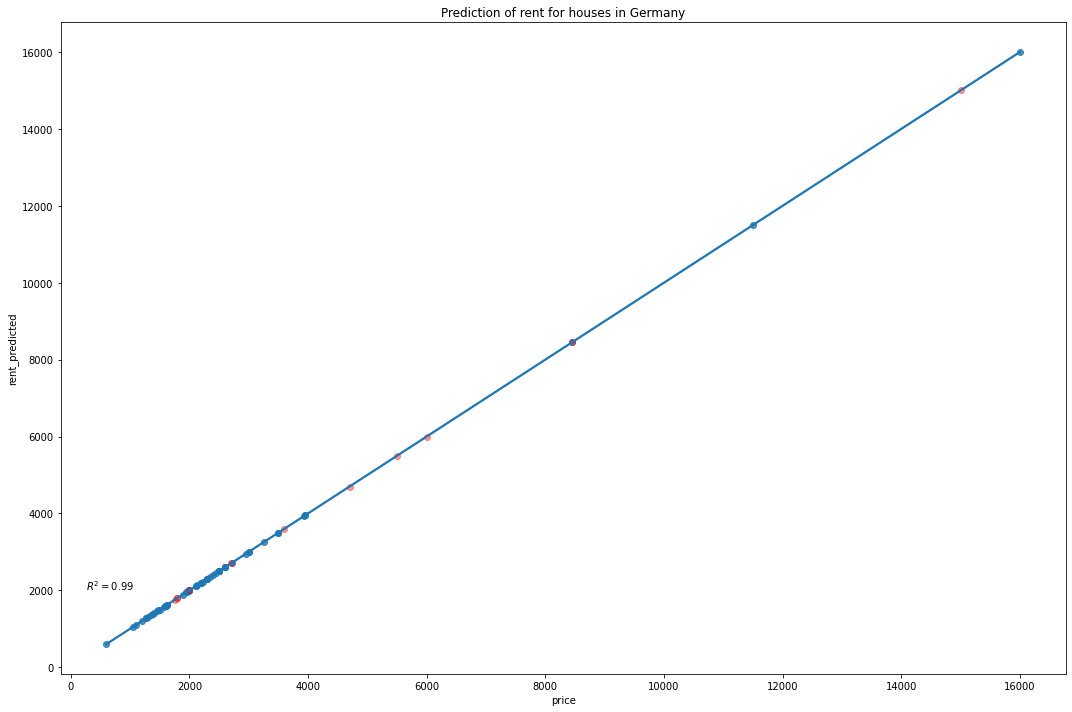

In [56]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.regplot(df_total['price'][inlier_mask],
            df_total['rent_predicted'][inlier_mask])
plt.scatter(df_total['price'][outlier_mask],
            df_total['rent_predicted'][outlier_mask],
            alpha=0.4,
            c='r')

plt.title('Prediction of rent for houses in Germany')
plt.text(250, 2000, r'$R^2=%.2f$' % r2_ransac)
plt.tight_layout()
# plt.savefig('LinReg-rent-apartment.png', dpi=150)

In [57]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, scoring="r2")
tpot.fit(X, y)
print(tpot.score(X, y))

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7184328540821535

Generation 2 - Current best internal CV score: 0.7196646055178023

Generation 3 - Current best internal CV score: 0.7196646055178023

Generation 4 - Current best internal CV score: 0.7196646055178023

Generation 5 - Current best internal CV score: 0.7196646055178023

Best pipeline: KNeighborsRegressor(SelectPercentile(input_matrix, percentile=72), n_neighbors=7, p=2, weights=distance)
0.9999907856004304


In [58]:
y_pred = tpot.predict(X)
r2_score(y, y_pred)

0.9999907856004304